In [1]:
import os
from random import sample
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Must be set before importing TF to supress messages
os.environ["CUDA_VISIBLE_DEVICES"]= '3'

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
from utils.loader import DataLoader
from utils.tools import test_model
from utils.data_sampler import CustomDataGenerator, CustomIterator
from utils.configs import config
from typing import List
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pickle

def load_VGG_model(img_height: int, img_width: int, lr: int, loss: tf.keras.losses.Loss, metrics: List[str], trainable: True) -> tf.keras.Model:
    """ Loads VGG-16 model.

    Args:
        img_height (int): Image height.
        img_width (int): Image width.
        lr (int): Learning rate.
        loss (tf.keras.losses.Loss): Model loss.
        metrics (List[str]): Training metrics.
        trainable (True): Set if model weights should be kept frozen or not.

    Returns:
        tf.keras.Model: TensorFlow VGG-16 model.
    """
    model = tf.keras.applications.vgg16.VGG16(input_shape=(img_height, img_width, 3))
    model.trainable = trainable
    model.compile(optimizer=tf.keras.optimizers.Adam(lr, epsilon=0.1),
                loss=loss,
                metrics=metrics)

    return model

In [2]:
img_height = 224
img_width = 224
batch_size = 1

# Set augmentation and pre-processing
test_datagen = CustomDataGenerator(
                    preprocessing_function=tf.keras.applications.vgg16.preprocess_input, dtype=tf.float32)

# Load ImageNet dataset with the VGG augmentation
loader = DataLoader(batch_size, (img_height, img_width))
test_set = loader.load_test_set(aug_test=test_datagen, set_batch_size=False)

Loading test set...
Found 48238 images belonging to 1000 classes.


In [3]:
model = load_VGG_model(img_height=224, img_width=224, lr=1e-3, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'], trainable=True)

In [5]:
# Get list of class folders
folder_names = list(os.walk(os.path.join(config['image_net_path'], config['test_path'])))[0][1]

In [6]:
# Get conversion of folder to names
conv_table = pd.read_table(os.path.join(config['externals'], 'imagenet1k_folder2labels.txt'), names=['folder', 'num', 'label'], delim_whitespace=True)
label_dict = dict(zip(list(conv_table['folder']), list(conv_table['label'])))

In [6]:
# Create model to ouput activation at end of block 4
layer_name = 'block4_conv3'
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

NMF

In [ ]:
n_comp = 3
model = sklearn.decomposition.NMF(n_components=n_comp, init='nndsvda', random_state=0, max_iter=300)
o_dict = {}
w_dict = {}

for j, od in enumerate(ord_dict.keys()):
    print(f'----{j}-----')
    arr_dict = {}
    for i in range(n_comp):
        arr_dict[i] = []
    ov_arr = []
    w_arr = []
    for i, cl in enumerate(ord_dict[od]):
        if i%20 ==0:
            print(f"{i}/{len(ord_dict[od])}")
        test_set.set_target_sampling([cl], [1])
        activations = intermediate_layer_model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
        activations = tf.reshape(activations, [activations.shape[0],-1]).numpy()
        W = model.fit_transform(activations)
        H = model.components_
        for i in range(n_comp):
            arr_dict[i].append(H[i, :].T)
        w_arr.append(np.var(W, axis=0)) # Store the average variance of each topic
    for i in range(n_comp):
        arr_dict[i] = np.vstack(arr_dict[i])
    w_arr = np.vstack(w_arr)
    w_dict[od] = np.mean(w_arr, axis=0)

    pca = PCA(1)
    for i in range(n_comp):
        el = arr_dict[i] - np.mean(arr_dict[i], axis=0)
        reduced = pca.fit(el)
        ov_arr.append(reduced.explained_variance_ratio_[0])
    o_dict[od] = ov_arr

In [ ]:
o_dict = dict(sorted(o_dict.items()))
w_dict = dict(sorted(w_dict.items()))
acc_dict = dict(sorted(acc_dict.items()))

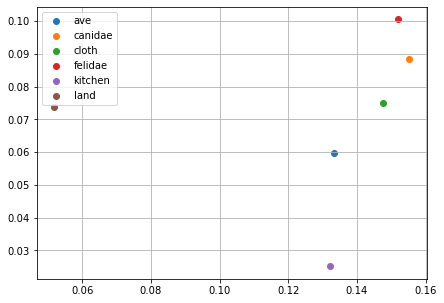

In [68]:
fig, ax = plt.subplots(figsize=(7,5))
for i, cl in enumerate(w_dict.keys()):
    ax.scatter( w_dict[cl][0], w_dict[cl][1],label=cl)
plt.grid()
ax.legend()

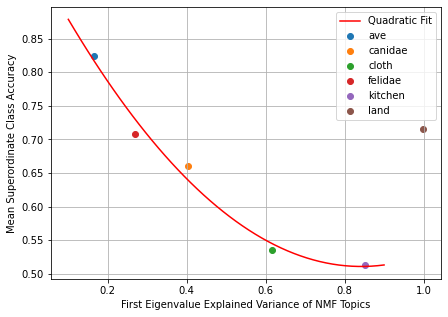

In [65]:
x = np.array(list(k[0] for k in o_dict.values())).reshape(-1, 1)
y = np.array(list(acc_dict.values())).reshape(-1, 1)
x_quad = np.hstack([x, x**2])
x_new = np.linspace(0.1, 0.9, 50).reshape(-1, 1)
x_new = np.hstack([x_new, x_new**2])
reg = sklearn.linear_model.LinearRegression().fit(x_quad[:-1, :], y[:-1, :])

fig, ax = plt.subplots(figsize=(7,5))
for i, cl in enumerate(o_dict.keys()):
    ax.scatter(x[i], y[i], label=cl)
ax.plot(x_new[:, 0], reg.predict(x_new), 'r', label='Quadratic Fit')
ax.grid()
ax.set_xlabel('First Eigenvalue Explained Variance of NMF Topics')
ax.set_ylabel('Mean Superordinate Class Accuracy')
plt.legend(loc='upper right')
#fig.savefig('pca_nmf_superordinates.png')

In [69]:
with open('nmf_ord_results.pkl', 'wb') as f:
    pickle.dump(o_dict, f)

In [ ]:
with open('nmf_ord_results.pkl', 'rb') as f:
    o_dict  = pickle.load(f)

In [ ]:
acc_dict = {}
for od in o_dict.keys():
    acc = []
    for cl in ord_dict[od]:
        acc.append(class_acc_[label_dict[cl]])
    acc_dict[od] = np.mean(acc)

In [10]:
with open('200.txt') as f: # 200 classes from paper
    classes = f.read()
    classes = classes.split(',')

In [77]:
count_dict = {}
for k,v in ord_dict.items():
    count = 0
    for cl in v:
        if cl in classes:
            count+=1
    count_dict[k] = count

In [7]:
folder_names = sorted(folder_names)

In [8]:
sem_vec = np.load('external_files/imagenet2vec_1k.npy')
sem_dict = {}
for cl in folder_names:
    sem_dict[cl] = sem_vec[folder_names.index(cl)]

In [9]:
cosine_sim = np.zeros((1000, 1000))
for i, cl in enumerate(folder_names):
    for j, cl2 in enumerate(folder_names):
        cosine_sim_score = np.dot(sem_dict[cl], sem_dict[cl2])/(np.linalg.norm(sem_dict[cl])*np.linalg.norm(sem_dict[cl2]))
        cosine_sim[i, j] = cosine_sim_score

In [36]:
new_od = {}
for row in range(cosine_sim.shape[0]):
    index = list(np.where(cosine_sim[row, :]>0.2)[0])
    index.remove(row)
    index = [[folder_names[idx],cosine_sim[row, idx]] for idx in index]
    new_od[folder_names[row]] = index

In [11]:
import networkx as nx
import community
import collections

In [37]:
g = nx.Graph()
g.add_nodes_from(list(new_od.keys()))
for k, v in new_od.items():
    for entry in v:
        g.add_edge(k, entry[0], weight=entry[1])

Affinity Prop Clustering

In [38]:
nn = len(g.nodes)
mat = np.empty((nn, nn), dtype=float)
mat.fill(-100.0)
np.fill_diagonal(mat, -0.0)
preds = nx.jaccard_coefficient(g, g.edges)
for u, v, j in preds:
    mat[folder_names.index(u),folder_names.index(v)] = -100 * (1 - j)

In [39]:
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(preference=-100, affinity="precomputed")
lab = af.fit_predict(mat)
len(np.unique(lab))

/home/mazin/.conda/envs/splash2/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


7

In [40]:
cluster_dict = {}
for idx in range(len(np.unique(lab))):
    cluster_dict[idx] = np.where(af.labels_==idx)[0].tolist()
for k,v in cluster_dict.items():
    cluster_dict[k] = [label_dict[folder_names[idx]] for idx in v]

In [42]:
with open('cluster_dict.pkl', 'wb') as f:
    pickle.dump(cluster_dict, f)

Community Clustering

In [ ]:
partition = community.best_partition(g)
values = [partition.get(node) for node in g.nodes()]
counter=collections.Counter(values)
print(counter)

In [75]:
groups_dict = {}
nodes_list = list(g.nodes())
for i, v in enumerate(values):
    if v not in groups_dict:
        groups_dict[v] = []
    groups_dict[v].append(label_dict[nodes_list[i]])

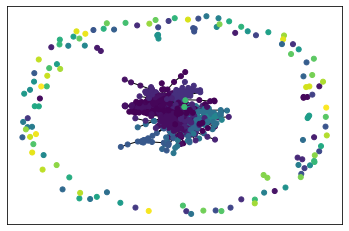

In [23]:
sp = nx.spring_layout(g)
nx.draw_networkx(g, pos=sp, with_labels=False, node_size=25, node_color=values)
# plt.axes('off')
plt.show()

Basic Variance of Activations

In [ ]:
basic_var_dict = {}
for i, cl in enumerate(label_dict.keys()):
    if i % 25 == 0:
        print(f'{i}/{len(label_dict)}')
    test_set.set_target_sampling([cl], [1])
    activations = intermediate_layer_model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    var = np.var(activations, axis =(1,2)) # Var within each filter
    var = np.var(var, axis=-1) # Var across variance of filters
    var = np.mean(var) # Mean variance across all inter-class samples
    basic_var_dict[label_dict[cl]] = var

In [21]:
basic_var_dict = dict(sorted(basic_var_dict.items(), key=lambda item: item[1], reverse=True))

In [69]:
with open('class_var.pkl', 'wb') as f:
    pickle.dump(basic_var_dict, f)

PCA Version

In [ ]:
var_dict = {}
pca = PCA(10)
# Perform PCA per class
for i, cl in enumerate(label_dict.keys()):
    if i % 25 == 0:
        print(f'{i}/{len(label_dict)}')
    test_set.set_target_sampling([cl], [1])
    activations = intermediate_layer_model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    activations = tf.reshape(activations, [activations.shape[0],-1]).numpy()
    activations = activations - np.mean(activations, axis=0)
    reduced = pca.fit(activations)
    var_dict[label_dict[cl]] = sum(reduced.explained_variance_ratio_)

In [79]:
with open('class_var_pca_centered.pkl', 'wb') as f:
    pickle.dump(var_dict, f)

In [7]:
with open('external_files/generated_saves/class_var.pkl', 'rb') as f:
    class_var  = pickle.load(f)
with open('external_files/generated_saves/class_var_pca.pkl', 'rb') as f:
    class_var_pca  = pickle.load(f)
with open('external_files/generated_saves/class_var_pca_comp.pkl', 'rb') as f:
    class_var_pca_comp  = pickle.load(f)
with open('external_files/generated_saves/class_acc.pkl', 'rb') as f:
    class_acc_ = pickle.load(f)

In [ ]:
var_dict = dict(sorted(var_dict.items(), key=lambda item: item[1], reverse=False))

In [16]:
class_var_pca = var_dict.copy()

Comparisons

In [12]:
var_pca_comp = set(list(class_var_pca_comp.keys())[:200]) # Explained var threshold set with 50% cap 
var_pca = set(list(class_var_pca.keys())[:200]) # First 5 PC's explained variance sum
base_var = set(list(class_var.keys())[:200]) # Basic variance
class_acc = set(list(class_acc_.keys())[:200]) # Per class accuracies 

In [13]:
overlap = class_acc.intersection(var_pca)
overlap2 = class_acc.intersection(var_pca_comp)
overlap3 = class_acc.intersection(base_var)

Ordinate check

In [32]:
ord_dict = {}
att_dict = {}
for ord in list(os.walk(os.path.join('external_files', 'imagenet_superordinates')))[0][2]:
    ord_dict[ord.split('_')[0]] = list(pd.read_csv(os.path.join('external_files', 'imagenet_superordinates', ord))['wnid'])

Main Experiment Comparisons

In [18]:
print(f'Overlap of lowest 200 (accuracy) classes to highest 200 basic variance:   {len(class_acc.intersection(base_var))}')
print(f'Overlap of lowest 200 (accuracy) classes to lowest 200 cumulative variance of first 5 PCs:   {len(class_acc.intersection(var_pca))}')
print(f'Overlap of lowest 200 (accuracy) classes to lowest 200 first N PCs w/50% expained variance:   {len(class_acc.intersection(var_pca_comp))}')

Overlap of lowest 200 (accuracy) classes to highest 200 basic variance:   42
Overlap of lowest 200 (accuracy) classes to lowest 200 cumulative variance of first 5 PCs:   30
Overlap of lowest 200 (accuracy) classes to lowest 200 first N PCs w/50% expained variance:   24


In [19]:
x_base, x_pca, x_pca_comp, y = [], [], [], []
for cl in list(overlap3):
    cl_conv = cl #label_dict[cl]
    x_base.append(class_var[cl_conv])
    x_pca.append(class_var_pca[cl_conv])
    x_pca_comp.append(class_var_pca_comp[cl_conv])
    y.append(class_acc_[cl_conv])

In [20]:
x_pca = (np.array(x_pca) - np.min(np.array(x_pca)))/(np.max(np.array(x_pca)) - np.min(np.array(x_pca)))
x_base = (np.array(x_base) - np.min(np.array(x_base)))/(np.max(np.array(x_base)) - np.min(np.array(x_base)))

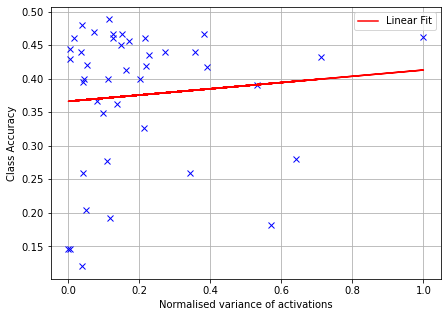

In [21]:
x_base = np.array(x_base)
reg = sklearn.linear_model.LinearRegression().fit(x_base.reshape(-1, 1), y)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_base, y, 'bx')
ax.plot(x_base, reg.predict(x_base.reshape(-1, 1)), 'r', label='Linear Fit')
ax.grid()
ax.set_xlabel('Normalised variance of activations')
ax.set_ylabel('Class Accuracy')
plt.legend(loc='upper right')
#fig.savefig('base_var_plot.png')

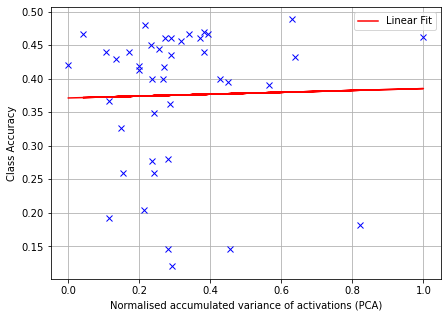

In [22]:
x_pca = np.array(x_pca)
reg = sklearn.linear_model.LinearRegression().fit(x_pca.reshape(-1, 1), y)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_pca, y, 'bx')
ax.plot(x_pca, reg.predict(x_pca.reshape(-1, 1)), 'r', label='Linear Fit')
ax.grid()
ax.set_xlabel('Normalised accumulated variance of activations (PCA)')
ax.set_ylabel('Class Accuracy')
plt.legend(loc='upper right')
#fig.savefig('pca_var_plot.png')

Text(0, 0.5, 'Class Accuracy')

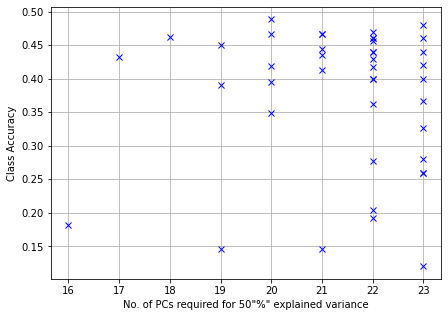

In [78]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_pca_comp, y, 'bx')
ax.grid()
ax.set_xlabel('No. of PCs required for 50"%" explained variance')
ax.set_ylabel('Class Accuracy')
#fig.savefig('pca_comp_var_plot.png')